# Capstone Project - The Battle of Neighborhoods in London

## Business Problem section 

#### Background

The UK is the second most popular study destination worldwide. According to official international enrollment statistics, 458,490 foreign students were attending university in UK. As a result London is a really popular destination for students. Eventhought the students can be acomodated by the universities most of the time they will need to find a home in order to keep living in the UK. When they initiate their searching they will quickly realise that the Housing Market is not in a good shape.

#### Business Problem

In this project i will try to assist home buyers located or moving in London to make optimal decisions using machine learning tools. As a result, the business problem we are currently posing is: how could we provide support to homebuyers clientele in purchasing a suitable piece of real estate in London in this uncertain economic and financial scenario? To solve this business problem, we are going to cluster London neighborhoods in order to recommend venues and the current average price of real estate where homebuyers can make a real estate investment. We will recommend affordable venues according to amenities and essential facilities surrounding such venues. Since our target group is students either coming in or graduating from Universities so we assume that their budget is limited from 100.000 to 300.000 pounds.




##  Data section

Data on London properties was extracted from the HM Land Registry (http://landregistry.data.gov.uk/). 

The following fields comprise the address data included in Price Paid Data: Postcode; PAON Primary Addressable Object Name. Typically the house number or name; SAON Secondary Addressable Object Name.

In order to find and recomend locations based on the presence of essential facilities, we will access data through FourSquare API interface and arrange them as a dataframe for visualization. 

By merging all the data gathered on London we will be able to recommend good buying oportunities for the homebuyers.


## Methodology section

The Methodology section will describe the main components of our analysis and predication system.
The Methodology section comprises four stages: 
    1. Collection of Needed Data
    2. Explore and Understand Data
    3. Data Wrangling 
    4. Modeling

#### 1. Collection of Needed Data

After importing the necessary libraries, we download the data from the HM Land Registry website as follows:

In [1]:
import os # Operating System
import numpy as np
import pandas as pd
import datetime as dt # Datetime
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.19.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.22 MB/s
geopy-1.19.0-p 100% |################################| Time: 0:00:00  10.24 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  10.38 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.36 MB/s
vincent-0.4.4- 100% |###################

In [2]:
#Read the first batch of data  (Source: http://landregistry.data.gov.uk/)
df = pd.read_csv("http://prod2.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2019.csv")

Now we are ready to Explore and Understand the Data.

#### 2. Explore and Understand Data

We read the first 5 rows to get a feel of the format of the dataframe : 

In [3]:
df.head(5) 

,{8355F009-BCC0-55C5-E053-6B04A8C0D090},110000,2019-02-08 00:00,TQ1 1NP,T,N,F,66,Unnamed: 8,PRINCES ROAD,Unnamed: 10,TORQUAY,TORBAY,TORBAY.1,B,A
0,{8355F009-BCC3-55C5-E053-6B04A8C0D090},225000,2019-01-17 00:00,EX32 0QW,S,N,F,6,NaN,OAKDALE AVENUE,SWIMBRIDGE,BARNSTAPLE,NORTH DEVON,DEVON,B,A
1,{8355F009-BCC4-55C5-E053-6B04A8C0D090},415000,2019-02-13 00:00,EX13 7RG,O,N,F,HURFORDS STORES,NaN,WHITFORD ROAD,KILMINGTON,AXMINSTER,EAST DEVON,DEVON,B,A
2,{8355F009-BCC5-55C5-E053-6B04A8C0D090},285000,2019-02-15 00:00,EX15 2PP,O,N,F,CHAPEL VIEW,NaN,SOMERVILLE ROAD,WILLAND,CULLOMPTON,MID DEVON,DEVON,B,A
3,{8355F009-BCC6-55C5-E053-6B04A8C0D090},360000,2019-01-30 00:00,EX5 2EB,O,N,F,1 INNER BROOMFIELD,NaN,LONDON ROAD,ROCKBEARE,EXETER,EAST DEVON,DEVON,B,A
4,{8355F009-BCC8-55C5-E053-6B04A8C0D090},95000,2019-01-31 00:00,EX39 3PN,O,N,L,LENWOOD COUNTRY CLUB,32B,LENWOOD ROAD,NORTHAM,BIDEFORD,TORRIDGE,DEVON,B,A


In [4]:
df.shape

(78004, 16)

After we saw the format of our data using the .head method from Pandas library we also asked for the shape of our dataframe using the .shape method and we saw that our first dataset consists of 78004 rows and 16 columns. It’s current format is not ideal to process so we have to proceed to the data wrangling phase to transform it in a useful manner.

#### 3. Data Wrangling

At this stage, we reshape our dataset for the modeling by: 

- Renaming the column names 
- Formating the date column 
- Sorting data by date of sale 
- Selecting data only for the city of London 
- Making a list of street names in London 
- Calculating the street-wise average price of the property
- Reading the street-wise coordinates into a data frame, eliminating recurring word London from individual names 
- Joining the data to find the coordinates of locations which fit into client's budget
- Plotting recommended locations on London map along with current market prices



In [5]:
# We assign proper column names
df.columns = ['ID', 'Price', 'Date_Transfer', 'Postcode', 'Prop_Type', 'Old_New', 'Duration', 'PAON', \
                  'SAON', 'Street', 'Locality', 'Town_City', 'District', 'County', 'PPD_Cat_Type', 'Record_Status']
# We view the first 5 rows to confirm our columns 
df.head()

,ID,Price,Date_Transfer,Postcode,Prop_Type,Old_New,Duration,PAON,SAON,Street,Locality,Town_City,District,County,PPD_Cat_Type,Record_Status
0,{8355F009-BCC3-55C5-E053-6B04A8C0D090},225000,2019-01-17 00:00,EX32 0QW,S,N,F,6,NaN,OAKDALE AVENUE,SWIMBRIDGE,BARNSTAPLE,NORTH DEVON,DEVON,B,A
1,{8355F009-BCC4-55C5-E053-6B04A8C0D090},415000,2019-02-13 00:00,EX13 7RG,O,N,F,HURFORDS STORES,NaN,WHITFORD ROAD,KILMINGTON,AXMINSTER,EAST DEVON,DEVON,B,A
2,{8355F009-BCC5-55C5-E053-6B04A8C0D090},285000,2019-02-15 00:00,EX15 2PP,O,N,F,CHAPEL VIEW,NaN,SOMERVILLE ROAD,WILLAND,CULLOMPTON,MID DEVON,DEVON,B,A
3,{8355F009-BCC6-55C5-E053-6B04A8C0D090},360000,2019-01-30 00:00,EX5 2EB,O,N,F,1 INNER BROOMFIELD,NaN,LONDON ROAD,ROCKBEARE,EXETER,EAST DEVON,DEVON,B,A
4,{8355F009-BCC8-55C5-E053-6B04A8C0D090},95000,2019-01-31 00:00,EX39 3PN,O,N,L,LENWOOD COUNTRY CLUB,32B,LENWOOD ROAD,NORTHAM,BIDEFORD,TORRIDGE,DEVON,B,A


In [6]:
# Format the date column
df['Date_Transfer'] = df['Date_Transfer'].apply(pd.to_datetime)

# Delete all obsolete transactions which were done before 2016
df.drop(df[df.Date_Transfer.dt.year < 2016].index, inplace=True)

# Sort by Date of Sale
df.sort_values(by=['Date_Transfer'],ascending=[False],inplace=True)

In [7]:
df_london = df.query("Town_City == 'LONDON'")

# Make a list of street names in LONDON
By_street = df_london['Street'].unique().tolist()

In [8]:
By_price = df_london.groupby(['Street'])['Price'].mean().reset_index()

# Give proper names to the columns
By_price.columns = ['Street', 'Avg_Price']

In [9]:
# We define our budget (i.e 100.000 to 300.000)
affordable = By_price.query("(Avg_Price >= 100000) & (Avg_Price <= 300000)")

In [10]:
# Display the dataframe
affordable

,Street,Avg_Price
20,ACORN CLOSE,240000.000000
24,ADDINGTON STREET,300000.000000
30,ADMASTON ROAD,265000.000000
64,ALESTAN BECK ROAD,260000.000000
68,ALFREDA STREET,200000.000000
90,AMBLECOTE ROAD,261500.000000
93,AMBLESIDE ROAD,300000.000000
101,ANDRE STREET,225000.000000
108,ANTHONY ROAD,300000.000000
125,ARNGASK ROAD,266000.000000


In [11]:
# We import the needed libraries 
import datetime as DT
import hmac
from geopy.distance import vincenty
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [12]:
geolocator = Nominatim(user_agent="dim.tagkoulis@gmail.com")

nom=Nominatim(domain='localhost:8080', scheme='http')

In [13]:
affordable['city_coord'] = affordable['Street'].apply(geolocator.geocode, timeout= 30).apply(lambda x: (x.latitude, x.longitude))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
affordable.head()

,Street,Avg_Price,city_coord
20,ACORN CLOSE,240000.0,"(53.4396884, -2.2027922)"
24,ADDINGTON STREET,300000.0,"(53.4860331, -2.2332156)"
30,ADMASTON ROAD,265000.0,"(51.479067, 0.0775778)"
64,ALESTAN BECK ROAD,260000.0,"(51.5141802, 0.041669)"
68,ALFREDA STREET,200000.0,"(51.474523, -0.1501641)"


In [15]:
affordable[['Latitude', 'Longitude']] = affordable['city_coord'].apply(pd.Series)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [16]:
affordable.head()

,Street,Avg_Price,city_coord,Latitude,Longitude
20,ACORN CLOSE,240000.0,"(53.4396884, -2.2027922)",53.439688,-2.202792
24,ADDINGTON STREET,300000.0,"(53.4860331, -2.2332156)",53.486033,-2.233216
30,ADMASTON ROAD,265000.0,"(51.479067, 0.0775778)",51.479067,0.077578
64,ALESTAN BECK ROAD,260000.0,"(51.5141802, 0.041669)",51.514180,0.041669
68,ALFREDA STREET,200000.0,"(51.474523, -0.1501641)",51.474523,-0.150164


In [17]:
df = affordable.drop(columns=['city_coord'])

In [18]:
print(df)

                      Street      Avg_Price   Latitude   Longitude
20               ACORN CLOSE  240000.000000  53.439688   -2.202792
24          ADDINGTON STREET  300000.000000  53.486033   -2.233216
30             ADMASTON ROAD  265000.000000  51.479067    0.077578
64         ALESTAN BECK ROAD  260000.000000  51.514180    0.041669
68            ALFREDA STREET  200000.000000  51.474523   -0.150164
90            AMBLECOTE ROAD  261500.000000  51.430724    0.023346
93            AMBLESIDE ROAD  300000.000000  51.543660   -0.246212
101             ANDRE STREET  225000.000000  45.307330  -75.090920
108             ANTHONY ROAD  300000.000000 -33.733249  150.995930
125             ARNGASK ROAD  266000.000000  55.857611   -4.327078
141           ASHBOURNE ROAD  160000.000000  52.929290   -1.505328
164            ATKINS SQUARE  246000.000000  51.549842   -0.058419
167            AUCKLAND RISE  270000.000000  51.411663   -0.082942
170             AUSTEN CLOSE  299000.000000  51.502489    0.11

In [19]:
address = 'London, UK'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London City are 51.5073219, -0.1276474.


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.19.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


In [20]:
# create map of London using latitude and longitude values
london_Map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, price, street in zip(df['Latitude'], df['Longitude'], df['Avg_Price'], df['Street']):
    label = '{}, {}'.format(street, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_Map)  
    
london_Map

In [21]:
# The code was removed by Watson Studio for sharing.

#### 4. Modeling

We will now use the k-means clustering technique to produce clusters in real estate market in London.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# Run the above function on each location and create a new dataframe called venues and display it.
venues = getNearbyVenues(names=df['Street'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

ACORN CLOSE
ADDINGTON STREET
ADMASTON ROAD
ALESTAN BECK ROAD
ALFREDA STREET
AMBLECOTE ROAD
AMBLESIDE ROAD
ANDRE STREET
ANTHONY ROAD
ARNGASK ROAD
ASHBOURNE ROAD
ATKINS SQUARE
AUCKLAND RISE
AUSTEN CLOSE
AVONLEY ROAD
BALTIMORE WHARF
BANNING STREET
BARRY ROAD
BARSON CLOSE
BARTLETT MEWS
BASIL STREET
BASING WAY
BASTION ROAD
BATHURST STREET
BEECHES CLOSE
BELL DRIVE
BELL GREEN LANE
BERGER ROAD
BETHNAL GREEN ROAD
BEVENDEN STREET
BLACKHEATH ROAD
BLONDIN STREET
BODDINGTON GARDENS
BONNER ROAD
BOOTH CLOSE
BOUNDARY ROAD
BOW ROAD
BOWER STREET
BRAEMAR AVENUE
BRANGWYN CRESCENT
BRINKLOW CRESCENT
BRITTEN CLOSE
BROAD LANE
BROADWAY
BROCKLEY RISE
BROOK SQUARE
BROWNHILL ROAD
BRUCE GROVE
BUNGALOW ROAD
BURNT ASH HILL
BURY STREET
BUSHEY ROAD
CALEDON ROAD
CAMDEN HILL ROAD
CAMPFIELD ROAD
CANDLE STREET
CARNABY STREET
CASTERBRIDGE ROAD
CATFORD HILL
CEDAR COURT
CENTRAL HILL
CHAMPION PARK
CHARLEMONT ROAD
CHARLES ROAD
CHARLTON PARK LANE
CHART STREET
CHAUNCEY CLOSE
CHESTERTON TERRACE
CHINGFORD MOUNT ROAD
CHURCH ROAD
CH

In [24]:
venues.head()

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ACORN CLOSE,53.439688,-2.202792,Iceland,53.443746,-2.204815,Grocery Store
1,ACORN CLOSE,53.439688,-2.202792,Burger King,53.443141,-2.205355,Fast Food Restaurant
2,ACORN CLOSE,53.439688,-2.202792,Fallowfield Loop,53.440696,-2.204225,Trail
3,ACORN CLOSE,53.439688,-2.202792,50 Bus Stop Kingsway / Moseley Road Bridge Lev...,53.441620,-2.203972,Bus Stop
4,ACORN CLOSE,53.439688,-2.202792,Bud Garden Centre,53.436572,-2.205475,Garden Center


In [25]:
venues.groupby('Street').count()

,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Street,,,,,,
ACORN CLOSE,8,8,8,8,8,8
ADDINGTON STREET,100,100,100,100,100,100
ADMASTON ROAD,5,5,5,5,5,5
ALESTAN BECK ROAD,4,4,4,4,4,4
ALFREDA STREET,22,22,22,22,22,22
AMBLECOTE ROAD,16,16,16,16,16,16
AMBLESIDE ROAD,4,4,4,4,4,4
ANDRE STREET,1,1,1,1,1,1
ANTHONY ROAD,3,3,3,3,3,3


In [26]:
# get the List of Unique Categories
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 371 uniques categories.


In [27]:
venues.shape

(5824, 7)

In [28]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add street column back to dataframe
venues_onehot['Street'] = venues['Street'] 

# move street column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])

#fixed_columns
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Street,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ACORN CLOSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACORN CLOSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACORN CLOSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACORN CLOSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACORN CLOSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
london_grouped = venues_onehot.groupby('Street').mean().reset_index()
london_grouped

,Street,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Vietnamese Restaurant,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ACORN CLOSE,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
1,ADDINGTON STREET,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020000,0.0,0.0,...,0.010000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
2,ADMASTON ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
3,ALESTAN BECK ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
4,ALFREDA STREET,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.045455,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
5,AMBLECOTE ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
6,AMBLESIDE ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
7,ANDRE STREET,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
8,ANTHONY ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000
9,ARNGASK ROAD,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000


In [30]:
london_grouped.shape

(337, 372)

In [31]:
# What are the top 5 venues/facilities nearby profitable real estate investments?#

num_top_venues = 5

for hood in london_grouped['Street']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Street'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ACORN CLOSE----
                  venue  freq
0  Fast Food Restaurant  0.12
1                 Trail  0.12
2         Grocery Store  0.12
3         Garden Center  0.12
4                 Plaza  0.12


----ADDINGTON STREET----
         venue  freq
0          Bar  0.11
1          Pub  0.08
2  Coffee Shop  0.08
3         Café  0.06
4  Pizza Place  0.04


----ADMASTON ROAD----
               venue  freq
0           Bus Stop   0.2
1  Convenience Store   0.2
2                Pub   0.2
3  Indian Restaurant   0.2
4      Grocery Store   0.2


----ALESTAN BECK ROAD----
               venue  freq
0  Convenience Store  0.25
1               Farm  0.25
2               Park  0.25
3           Bus Stop  0.25
4                ATM  0.00


----ALFREDA STREET----
                 venue  freq
0                  Pub  0.14
1                  Bar  0.14
2   Italian Restaurant  0.09
3                Hotel  0.05
4  Fried Chicken Joint  0.05


----AMBLECOTE ROAD----
               venue  freq
0           Platform

In [32]:
# Define a function to return the most common venues/facilities nearby real estate investments#

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))



In [34]:
# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Street'] = london_grouped['Street']

for ind in np.arange(london_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)



In [35]:
venues_sorted.head()

,Street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACORN CLOSE,Garden Center,Bus Stop,Trail,Fast Food Restaurant,Pet Store,Discount Store,Grocery Store,Plaza,Fish Market,Food
1,ADDINGTON STREET,Bar,Coffee Shop,Pub,Café,Tea Room,Pizza Place,Fish & Chips Shop,Record Shop,Bookstore,Indian Restaurant
2,ADMASTON ROAD,Convenience Store,Bus Stop,Grocery Store,Pub,Indian Restaurant,Airport Service,Event Service,Exhibit,Falafel Restaurant,Farm
3,ALESTAN BECK ROAD,Convenience Store,Farm,Park,Bus Stop,Food & Drink Shop,Field,Food Service,Event Space,Exhibit,Falafel Restaurant
4,ALFREDA STREET,Pub,Bar,Italian Restaurant,Train Station,Chinese Restaurant,Café,Burger Joint,Spanish Restaurant,Sports Bar,Fried Chicken Joint


In [36]:
venues_sorted.shape

(337, 11)

In [37]:
london_grouped.shape

(337, 372)

In [38]:
london_grouped=df

After our inspection of venues near the real estate in our ptice range, we can begin clustering the properties. 

In [39]:
#Distribute in 3 Clusters

# set number of clusters
kclusters = 3

london_clustered = london_grouped.drop('Street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_clustered)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       2, 2, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2,
       2, 0, 1, 1], dtype=int32)

In [40]:
#Dataframe to include Clusters

london_clustered=df
london_clustered.head()

,Street,Avg_Price,Latitude,Longitude
20,ACORN CLOSE,240000.0,53.439688,-2.202792
24,ADDINGTON STREET,300000.0,53.486033,-2.233216
30,ADMASTON ROAD,265000.0,51.479067,0.077578
64,ALESTAN BECK ROAD,260000.0,51.514180,0.041669
68,ALFREDA STREET,200000.0,51.474523,-0.150164


In [41]:
london_clustered.shape

(362, 4)

In [42]:
df.shape

(362, 4)

In [43]:
london_clustered.dtypes

Street        object
Avg_Price    float64
Latitude     float64
Longitude    float64
dtype: object

In [44]:
df.dtypes

Street        object
Avg_Price    float64
Latitude     float64
Longitude    float64
dtype: object

In [45]:
# add clustering labels
london_clustered['Cluster Labels'] = kmeans.labels_

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_clustered = london_clustered.join(venues_sorted.set_index('Street'), on='Street')

london_clustered.head(30) 

,Street,Avg_Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,ACORN CLOSE,240000.0,53.439688,-2.202792,2,Garden Center,Bus Stop,Trail,Fast Food Restaurant,Pet Store,Discount Store,Grocery Store,Plaza,Fish Market,Food
24,ADDINGTON STREET,300000.0,53.486033,-2.233216,1,Bar,Coffee Shop,Pub,Café,Tea Room,Pizza Place,Fish & Chips Shop,Record Shop,Bookstore,Indian Restaurant
30,ADMASTON ROAD,265000.0,51.479067,0.077578,1,Convenience Store,Bus Stop,Grocery Store,Pub,Indian Restaurant,Airport Service,Event Service,Exhibit,Falafel Restaurant,Farm
64,ALESTAN BECK ROAD,260000.0,51.514180,0.041669,1,Convenience Store,Farm,Park,Bus Stop,Food & Drink Shop,Field,Food Service,Event Space,Exhibit,Falafel Restaurant
68,ALFREDA STREET,200000.0,51.474523,-0.150164,2,Pub,Bar,Italian Restaurant,Train Station,Chinese Restaurant,Café,Burger Joint,Spanish Restaurant,Sports Bar,Fried Chicken Joint
90,AMBLECOTE ROAD,261500.0,51.430724,0.023346,1,Platform,Grocery Store,Park,Pub,Train Station,Gym / Fitness Center,Fried Chicken Joint,Food & Drink Shop,Fast Food Restaurant,Coffee Shop
93,AMBLESIDE ROAD,300000.0,51.543660,-0.246212,1,Caribbean Restaurant,Fish & Chips Shop,Park,Discount Store,Food & Drink Shop,Field,Food Service,Event Space,Exhibit,Falafel Restaurant
101,ANDRE STREET,225000.0,45.307330,-75.090920,2,Coffee Shop,Yoga Studio,Financial or Legal Service,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
108,ANTHONY ROAD,300000.0,-33.733249,150.995930,1,Park,Dry Cleaner,Mediterranean Restaurant,Yoga Studio,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
125,ARNGASK ROAD,266000.0,55.857611,-4.327078,1,Gas Station,Gym,Pizza Place,Bakery,Financial or Legal Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market


In [46]:
# Create Map

map_clustered = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_clustered['Latitude'], london_clustered['Longitude'], london_clustered['Street'], london_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustered)
       
map_clustered

In [47]:
Cluster_0=london_clustered.loc[london_clustered['Cluster Labels'] == 0, london_clustered.columns[[1] + list(range(5, london_clustered.shape[1]))]]
Cluster_0.head()
Cluster_0.shape

(69, 11)

In [48]:
Cluster_1=london_clustered.loc[london_clustered['Cluster Labels'] == 1, london_clustered.columns[[1] + list(range(5, london_clustered.shape[1]))]]
Cluster_1.head()
Cluster_1.shape

(183, 11)

In [49]:
Cluster_2=london_clustered.loc[london_clustered['Cluster Labels'] == 2, london_clustered.columns[[1] + list(range(5, london_clustered.shape[1]))]]
Cluster_2.head()
Cluster_2.shape

(110, 11)

Now that we have created and viewed our clusters we can clearly see that Cluster 0 (Lowest Prices) is the smallest having only 69 Venue Categories while Cluster 1 (Highest Prices) is the largest having 183 Venue Categories and our mid price Cluster 2 is sitting in between with 110 Venue Categories. We can easily conclude that as the price rises we can expect increasingle more variance in Venues.

Now lets see how many instanses of every Venue we have per Cluster:

In [78]:
#First we drop column Avg_Price
C0=Cluster_0.drop(columns='Avg_Price')
#Then we count how many times each Venue apears per row
C0=C0.apply(pd.value_counts)
#We replace NaN values with 0
C0=C0.fillna(0)
#And we Sum each row to get the number each Venue apeared
C0.loc[:,'Total']= C0.sum(axis=1)
C0=C0.drop(C0.columns[[0,1,2,3,4,5,6,7,8,9]], axis = 1)
#We put the index into a column so we can plot more easily
C0['Venues'] = C0.index
#We rearange the dataframe
C0 = C0[['Venues', 'Total']]
C0=C0.sort_values(by='Total', ascending=False)
#And finaly we drop the old index
C0.reset_index(drop=True, inplace=True)

C0.head(10)

,Venues,Total
0,Pub,30.0
1,Exhibit,29.0
2,Event Service,26.0
3,Falafel Restaurant,26.0
4,Event Space,26.0
5,Café,25.0
6,Fast Food Restaurant,22.0
7,Grocery Store,22.0
8,Farm,21.0
9,Coffee Shop,18.0


In [70]:
C0.sum()

Total    640.0
dtype: float64

In [77]:
#First we drop column Avg_Price
C1=Cluster_1.drop(columns='Avg_Price')
#Then we count how many times each Venue apears per row
C1=C1.apply(pd.value_counts)
#We replace NaN values with 0
C1=C1.fillna(0)
#And we Sum each row to get the number each Venue apeared
C1.loc[:,'Total']= C1.sum(axis=1)
C1=C1.drop(C1.columns[[0,1,2,3,4,5,6,7,8,9]], axis = 1)
#We put the index into a column so we can plot more easily
C1['Venues'] = C1.index
#We rearange the dataframe
C1 = C1[['Venues', 'Total']]
C1=C1.sort_values(by='Total', ascending=False)
#And finaly we drop the old index
C1.reset_index(drop=True, inplace=True)

C1.head(10)

,Venues,Total
0,Exhibit,75.0
1,Event Space,74.0
2,Pub,71.0
3,Grocery Store,70.0
4,Falafel Restaurant,64.0
5,Café,62.0
6,Event Service,56.0
7,Coffee Shop,54.0
8,Park,49.0
9,Farm,49.0


In [67]:
C1.sum()

Total    1680.0
dtype: float64

In [83]:
#First we drop column Avg_Price
C2=Cluster_2.drop(columns='Avg_Price')
#Then we count how many times each Venue apears per row
C2=C2.apply(pd.value_counts)
#We replace NaN values with 0
C2=C2.fillna(0)
#And we Sum each row to get the number each Venue apeared
C2.loc[:,'Total']= C2.sum(axis=1)
C2=C2.drop(C2.columns[[0,1,2,3,4,5,6,7,8,9]], axis = 1)
#We put the index into a column so we can plot more easily
C2['Venues'] = C2.index
#We rearange the dataframe
C2 = C2[['Venues', 'Total']]
C2=C2.sort_values(by='Total', ascending=False)
#And finaly we drop the old index
C2.reset_index(drop=True, inplace=True)

C2.head(10)

,Venues,Total
0,Event Space,52.0
1,Exhibit,51.0
2,Pub,45.0
3,Falafel Restaurant,45.0
4,Grocery Store,40.0
5,Event Service,37.0
6,Fast Food Restaurant,35.0
7,Coffee Shop,35.0
8,Café,34.0
9,Park,33.0


In [73]:
C2.sum()

Total    1050.0
dtype: float64

We can calculate how dense in terms of velues is each Cluster by dividing the number of venues within it by the the total real estate:

In [79]:
Dens_0=640/69
print('Cluster_0 has', Dens_0,'venues per property.')

Cluster_0 has 9.27536231884058 venues per property.


In [69]:
Dens_1=1680/183
print('Cluster_1 has', Dens_1,'venues per property.')

Cluster_1 has 9.180327868852459 venues per property.


In [65]:
Dens_2=1050/110
print('Cluster_2 has', Dens_2,'venues per property.')

Cluster_2 has 9.545454545454545 venues per property.


It is clear that all three Clusters have more or less the same venue density regardless of price so we have to look elsewhere to identify the reasons for the price differences.

We plot each Cluster showing the frequency of wich venue appears within it (we chose the top 20 Venues per Cluster to make the plot easier to understand:

In [85]:
#We drop all rows that have lower than 10 total occurances
C0 = C0[C0.Total >= 10]

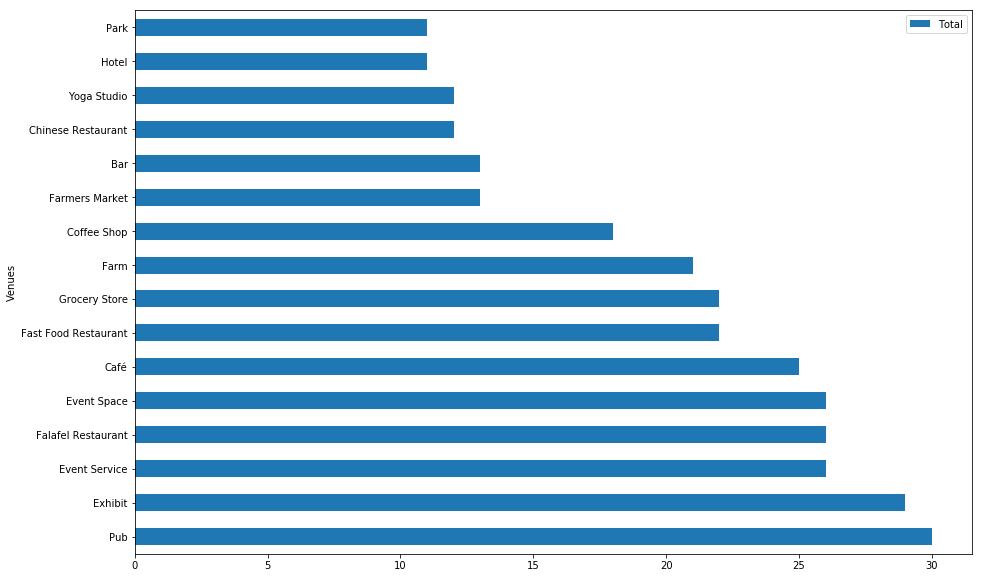

In [102]:
B0=C0.plot(C0['Venues'], kind='barh', figsize=(15,10))
B0

In [104]:
#We drop all rows that have lower than 10 total occurances
C1 = C1[C1.Total >= 10]

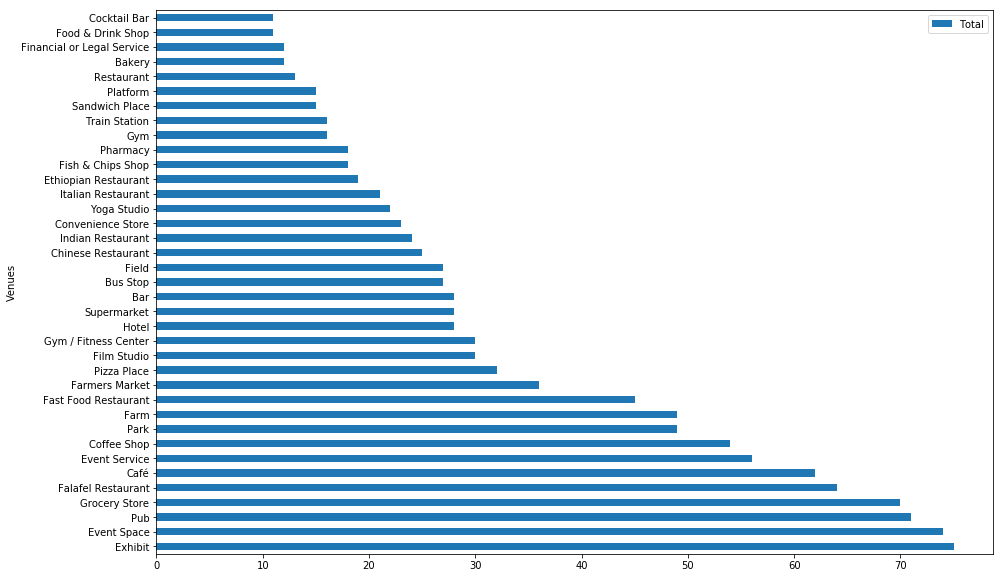

In [105]:
B1=C1.plot(C1['Venues'], kind='barh', figsize=(15,10))
B1

In [106]:
#We drop all rows that have lower than 10 total occurances
C2 = C2[C2.Total >= 10]

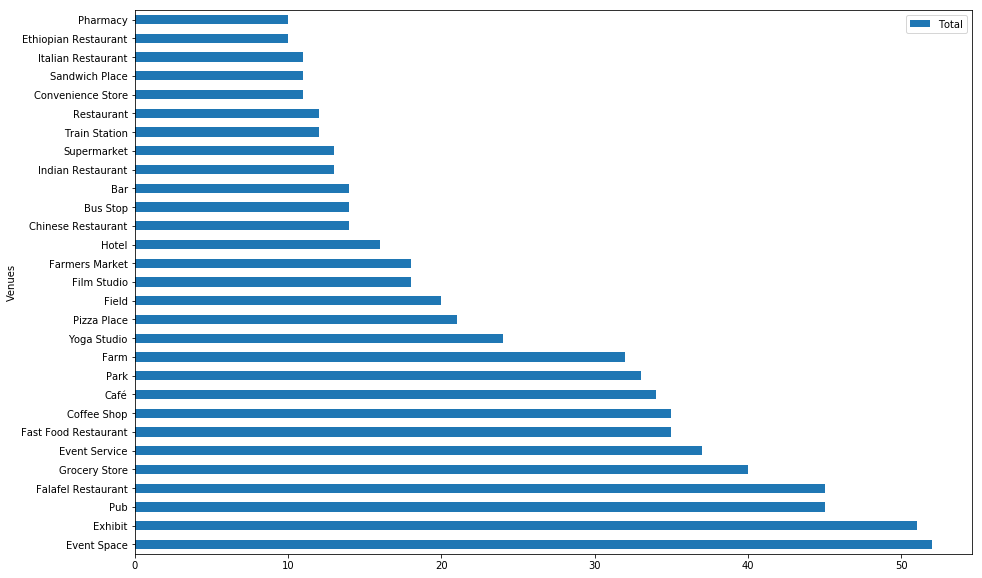

In [107]:
B2=C2.plot(C2['Venues'], kind='barh', figsize=(15,10))
B2

## Results and Discussion section

First of all, even though the London Housing Market has relatively high prices, finding affordable homes is still possible.

We may discuss our results for every Cluster. In terms of price our Clusters can be sorted on three Tiers:


#### High: Cluster 1 (Purple)
As the Higher end Tier this Cluster is the most complete having both vital venues such as Convenience Stores and Food and Drink stores , whie also having Higher end Venues such as Airport Services and all kinds of cuisines and services.

#### MId: Cluster 2 (Green)
As the mid Tier this Cluster seems more balanced in terms of Venues having both lower end (i.e coffe shops, Grocery stores) and some unique and higher end one (airport and train stations , foreing cuisine, legal services). Thanks to that balance this Cluster is our go to choise.

#### Low: Clusters 0 (Red) 
The final Tier has the lowest Avg prices.It doesn't have higher end Venues (ex. foreighn cuisine or services) with some exceptions on Cluster 1 so that definetely plays a role o the reduced prices. Such facilities are not essential for a student so this cluster should be prioritized.




## Conclusion


To solve our business problem, we clustered London neighborhoods in order to identify afordable homes depending on nearby venues and the current average price of real estate where homebuyers can live. We recommended profitable venues according to amenities and essential facilities surrounding such venues i.e. elementary schools, high schools, hospitals & grocery stores.

First, we gathered data on London properties and the relative price paid data were extracted from the HM Land Registry (http://landregistry.data.gov.uk/). Moreover, to explore and target recommended locations across different venues according to the presence of essential facilities, we accessed data through FourSquare API interface and cross refferenced them with the Registry data. By cross refferencing the data on London properties and the data from FourSquare API interface, we were able to identify real estate investments that both fall into our budget and have enough nearby venues to support different lifestyles. 

Second, The Methodology section comprised four stages: 1. Collect Needed Data; 2. Explore and Understand Data; 3. Data Wrangling; 4. Modeling. We chose the k-means clustering technique as it is the most efficient in terms of computational cost, and it is highly flexible and accurate.

Finally, we further grouped our 3 Clusters into three Tiers based on price range to try to identify what kind of homebuyer is best served by them. 

